# Proyek Klasifikasi Gambar: [Garbage Classification](https://www.kaggle.com/datasets/mostafaabla/garbage-classification/data)
- **Nama:** Krisna Santosa
- **Email:** mamang.krisna15@gmail.com
- **ID Dicoding:** [krisna_santosa](https://www.dicoding.com/users/krisna_santosa/)

## Deskripsi Proyek

Sampah merupakan masalah yang sering dihadapi oleh masyarakat di berbagai negara. Sampah yang tidak dikelola dengan baik akan menimbulkan masalah lingkungan yang serius. Oleh karena itu, diperlukan suatu sistem yang dapat mengelompokkan sampah menjadi beberapa kategori agar dapat dikelola dengan baik. Pada proyek ini, akan dilakukan klasifikasi sampah menjadi 12 kategori berbeda menggunakan teknik deep learning. Dataset yang digunakan adalah dataset [Garbage Classification](https://www.kaggle.com/mostafaabla/garbage-classification) yang terdiri dari 12 kategori sampah berbeda seperti kertas, kardus, botol, kaleng, gelas, dan lain-lain. Jumlah total gambar pada dataset ini adalah 15.000+ gambar dengan resolusi yang bervariasi. 

## Import Semua Packages/Library yang Digunakan

In [18]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path
import pandas as pd
import os
from typing import Dict, List, Union
import requests
import logging

In [3]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

## Data Preparation

### Data Loading

In [4]:
data_dir = '/kaggle/input/garbage-classification/garbage_classification'

In [46]:
# Exploration
from PIL import Image
import os
 
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0
 
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images
 
        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")
 
    print(f"\nTotal: {total_images}")

In [5]:
print_images_resolution(data_dir)

metal: 769
- (225, 224)
- (200, 252)
- (363, 139)
- (201, 251)
- (223, 226)
- (220, 218)
- (276, 183)
- (150, 150)
- (199, 253)
- (259, 194)
- (180, 157)
- (347, 145)
- (266, 190)
- (272, 185)
- (258, 195)
- (287, 176)
- (247, 204)
- (270, 187)
- (339, 149)
- (256, 197)
- (262, 192)
- (245, 206)
- (291, 173)
- (246, 205)
- (251, 201)
- (306, 164)
- (309, 163)
- (349, 144)
- (298, 169)
- (260, 194)
- (249, 203)
- (250, 202)
- (233, 216)
- (180, 180)
- (234, 215)
- (293, 172)
- (318, 159)
- (248, 204)
- (232, 217)
- (235, 215)
- (236, 214)
- (310, 163)
- (224, 224)
- (271, 186)
- (276, 182)
- (220, 229)
- (225, 225)
- (275, 183)
- (261, 193)
- (174, 289)
- (266, 189)
- (287, 175)
- (250, 199)
- (265, 190)
- (294, 171)
- (297, 170)
- (254, 199)
- (285, 177)
- (286, 176)
- (184, 275)
- (277, 182)
- (269, 187)
- (311, 162)
- (280, 156)
- (300, 168)
- (243, 207)
- (306, 165)
- (307, 164)
- (207, 244)
- (208, 243)
- (228, 221)
- (236, 213)
- (227, 222)
- (200, 253)
- (278, 181)
- (477, 106)
-

In [5]:
classes = os.listdir(data_dir)
print(f"Classes: {classes}")

for class_name in classes:
    num_images = len(os.listdir(os.path.join(data_dir, class_name)))
    print(f"{class_name}: {num_images} images")


Classes: ['metal', 'white-glass', 'biological', 'paper', 'brown-glass', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic', 'green-glass']
metal: 769 images
white-glass: 775 images
biological: 985 images
paper: 1050 images
brown-glass: 607 images
battery: 945 images
trash: 697 images
cardboard: 891 images
shoes: 1977 images
clothes: 5325 images
plastic: 865 images
green-glass: 629 images


In [7]:
image_dir = Path(data_dir)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

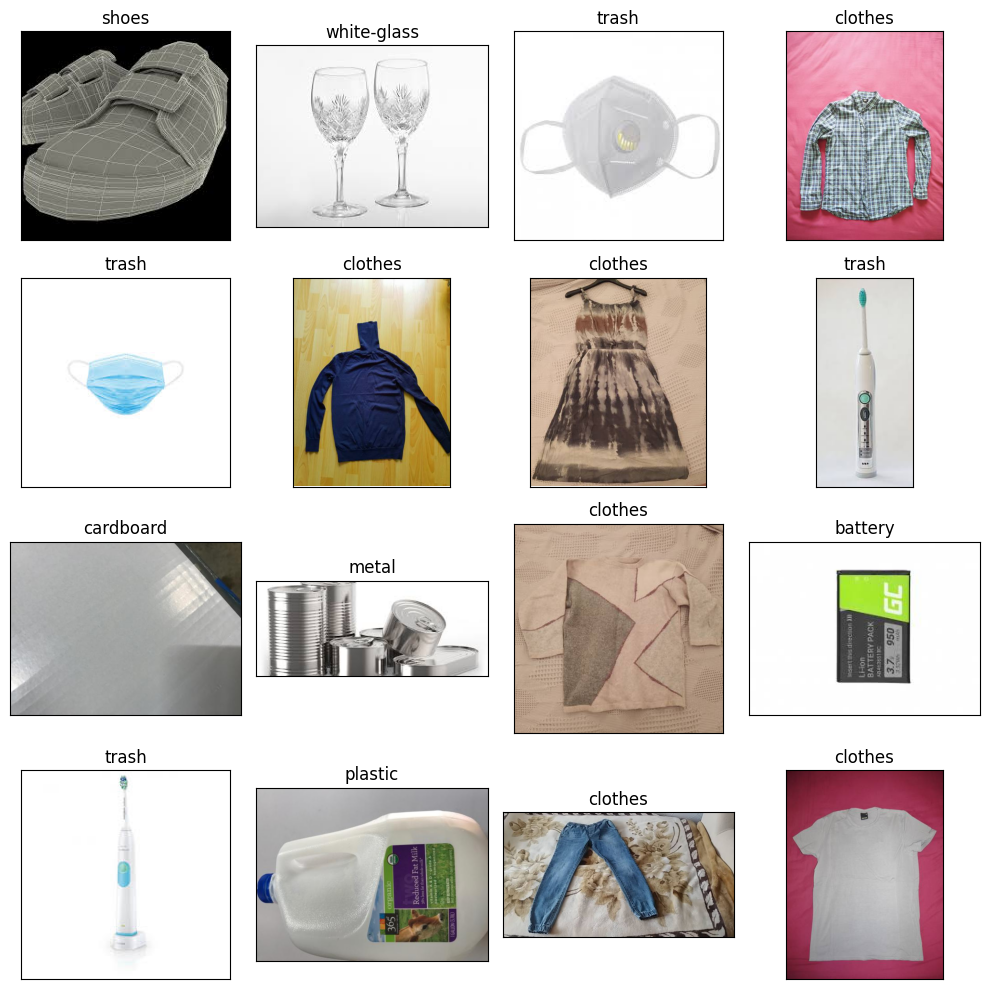

In [8]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 20)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [4]:
# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNEL = 3
BATCH_SIZE = 64
EPOCHS = 20

### Data Preprocessing

#### Split Dataset

In [7]:
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

base_dir = "/kaggle/working"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Divide for each class
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    images = np.array(os.listdir(class_path))

    # Split data: 80% train, 10% val, 10% test
    train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    for split_name, split_images in zip(["train", "val", "test"], [train_images, val_images, test_images]):
        split_class_dir = os.path.join(base_dir, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img in split_images:
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(split_class_dir, img)
            shutil.copy(src_path, dst_path)

print("Dataset successfully divided into train, validation and test set!")


Dataset successfully divided into train, validation and test set!


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("Data Loaded Successfully!")


Found 12409 images belonging to 12 classes.
Found 1550 images belonging to 12 classes.
Found 1556 images belonging to 12 classes.
Data Loaded Successfully!


## Modelling

In [ ]:
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), include_top=False, weights='imagenet')
base_model.trainable = False

for layer in base_model.layers[:20]:
    layer.trainable = True

# Sequential Model
with tf.device('/device:GPU:0'):
    model = Sequential([
        base_model,
        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])


initial_learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
# Config Callbaks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [18]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.6801 - loss: 2.5268
Epoch 1: val_accuracy improved from -inf to 0.67161, saving model to best_model.keras
194/194 ━━━━━━━━━━━━━━━━━━━━ 181s 834ms/step - accuracy: 0.6807 - loss: 2.5191 - val_accuracy: 0.6716 - val_loss: 1.1313 - learning_rate: 0.0010
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.8910 - loss: 0.3527
Epoch 2: val_accuracy did not improve from 0.67161
194/194 ━━━━━━━━━━━━━━━━━━━━ 159s 792ms/step - accuracy: 0.8910 - loss: 0.3527 - val_accuracy: 0.6335 - val_loss: 1.3590 - learning_rate: 0.0010
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.9059 - loss: 0.2921
Epoch 3: val_accuracy improved from 0.67161 to 0.74452, saving model to best_model.keras
194/194 ━━━━━━━━━━━━━━━━━━━━ 160s 796ms/step - accuracy: 0.9060 - loss: 0.2921 - val_accuracy: 0.7445 - val_loss: 0.9183 - learning_rate: 0.0010
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.9096 - 

## Evaluasi dan Visualisasi

In [19]:
# Evaluate the model
evaluation = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)
 
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9663 - loss: 0.1369
Loss: 0.15687936544418335
Accuracy: 0.9557291865348816


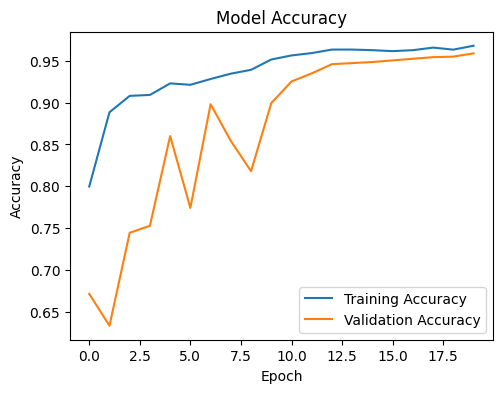

In [20]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

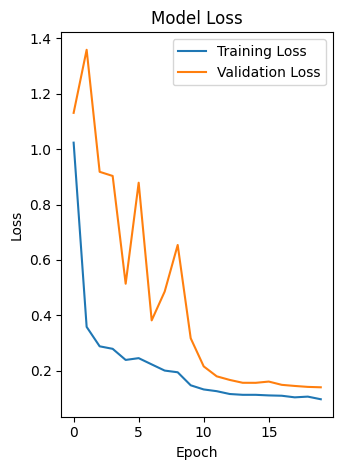

In [21]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [22]:
# Save model in SavedModel format
tf.saved_model.save(model, 'saved_model')

In [ ]:
# TF Lite conversion
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = converter.convert()

with tf.io.gfile.GFile('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
# Labels for TF Lite
LABEL_MAP = {
    0: 'battery',
    1: 'biological',
    2: 'brown-glass',
    3: 'cardboard',
    4: 'clothes',
    5: 'green-glass',
    6: 'metal',
    7: 'paper',
    8: 'plastic',
    9: 'shoes',
    10: 'trash',
    11: 'white-glass'
}

with open("tflite/labels.txt", "w") as f:
    for i in range(len(LABEL_MAP)):
        f.write(f"{LABEL_MAP[i]}\n")


In [41]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.8 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq

In [ ]:
# Convert to TFJS
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /kaggle/working/saved_model/ \
    /kaggle/working/tfjs_model

2025-02-21 10:52:14.776002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-21 10:52:14.795869: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-21 10:52:14.801893: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1740135138.577945     824 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740135138.578372     824 cuda_executor.cc:1015] succ

## Inference (Optional)

In [10]:
# Logging Config
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Label Constants
LABEL_MAP = {
    0: 'battery',
    1: 'biological',
    2: 'brown-glass',
    3: 'cardboard',
    4: 'clothes',
    5: 'green-glass',
    6: 'metal',
    7: 'paper',
    8: 'plastic',
    9: 'shoes',
    10: 'trash',
    11: 'white-glass'
}

def load_and_preprocess_image(file_path: Union[str, Path], target_size: tuple = (224, 224)) -> List[List[List[List[float]]]]:
    """
    Load and preprocess an image for classification.
    
    Args:
        file_path: Path to the image file
        target_size: Tuple of (height, width) for resizing
    
    Returns:
        Preprocessed image tensor as a nested list
    """
    try:
        file_path = Path(file_path)
        if not file_path.is_file():
            raise FileNotFoundError(f"Image file not found: {file_path}")
            
        with open(file_path, 'rb') as f:
            image = tf.io.decode_image(f.read(), channels=3)
            
        image = tf.image.resize(image, target_size)
        image = image / 255.0
        image_tensor = tf.expand_dims(image, 0)
        
        return image_tensor.numpy().tolist()
        
    except Exception as e:
        logger.error(f"Error preprocessing image: {str(e)}")
        raise

def predict_image(image_tensor: List[List[List[List[float]]]], endpoint: str) -> Dict[str, Union[str, float, List[Dict[str, float]]]]:
    """
    Send image to classification endpoint and get predictions.
    
    Args:
        image_tensor: Preprocessed image tensor
        endpoint: URL of the classification API endpoint
    
    Returns:
        Dictionary containing:
        - confidence_scores: Raw prediction scores
        - predicted_class: The class with highest confidence
        - all_predictions: List of all classes with their confidence scores
    """
    try:
        request_data = {"instances": image_tensor}
        response = requests.post(endpoint, json=request_data)
        response.raise_for_status()
        
        predictions = response.json()['predictions'][0]
        predicted_class_idx = tf.argmax(predictions).numpy()
        
        all_predictions = [
            {
                'label': LABEL_MAP[idx],
                'confidence': float(score)
            }
            for idx, score in enumerate(predictions)
        ]
        
        # Sort predictions by confidence
        all_predictions.sort(key=lambda x: x['confidence'], reverse=True)
        
        return {
            'confidence_scores': predictions,
            'predicted_class': LABEL_MAP[predicted_class_idx],
            'all_predictions': all_predictions
        }
        
    except Exception as e:
        logger.error(f"Prediction error: {str(e)}")
        raise

def process_and_predict(image_path: str, endpoint: str) -> Dict[str, Union[str, float, List[Dict[str, float]]]]:
    """
    Process an image and get predictions in one step.
    
    Args:
        image_path: Path to the image file
        endpoint: URL of the classification API endpoint
    
    Returns:
        Dictionary containing prediction results and confidence scores for all classes
    """
    logger.info(f"Processing image: {image_path}")
    image_tensor = load_and_preprocess_image(image_path)
    
    logger.info("Getting predictions...")
    result = predict_image(image_tensor, endpoint)
    
    logger.info(f"Predicted class: {result['predicted_class']}")
    return result

In [16]:
image_path = 'metal118.jpg'
endpoint = "http://localhost:8501/v1/models/garbage_classifier:predict"

try:
    result = process_and_predict(image_path, endpoint)
    print(f"\nTop prediction: {result['predicted_class']}")
    print("\nAll predictions sorted by confidence:")
    for pred in result['all_predictions']:
        print(f"{pred['label']}: {pred['confidence']:.6f}")
    print(f"\nAll Confidence Score:\n{result['confidence_scores']}")
except Exception as e:
    logger.error(f"Process failed: {str(e)}")

INFO:__main__:Processing image: metal118.jpg
INFO:__main__:Getting predictions...
INFO:__main__:Predicted class: metal



Top prediction: metal

All predictions sorted by confidence:
metal: 0.999981
white-glass: 0.000018
plastic: 0.000001
brown-glass: 0.000000
battery: 0.000000
paper: 0.000000
shoes: 0.000000
green-glass: 0.000000
trash: 0.000000
biological: 0.000000
clothes: 0.000000
cardboard: 0.000000

All Confidence Score:
[3.08669676e-08, 3.2730112e-12, 3.69668882e-08, 1.80436192e-13, 1.9953132e-12, 1.7446726e-10, 0.999980807, 1.20941817e-08, 1.24994142e-06, 3.60986713e-10, 7.59871402e-11, 1.78440241e-05]
